In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc
print(pc.__version__)

2024-08-03 18:51:47.161217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/christophemorisset/anaconda3/envs/ML/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


0.9.15b1


In [2]:
# Tell pyCloudy where the executable is to be found
pc.config.cloudy_exe = '/usr/local/Cloudy/cloudy-Tokyo24/source/cloudy.exe'

In [3]:
# Define the directory where the models will be run
dir_ = '../models'

In [4]:
# The following function write N files corresponding to different angles
# of an elliptical PN

def set_models(model_name, N=6, Teff=80000., QH=47.3, a=2.):
    """
    model_name: generic name for the models
    N: number of models
    Teff: effective temperature of the central BB
    QH: number of ionizing photons of the central BB
    a: ellipsicity
    """
    emis_tab = ['H  1  4861.33A',
            'H  1  6562.81A',
            'Ca B  5875.64A',
            'N  2  6583.45A',
            'O  1  6300.30A',
            'O  2  3726.03A',
            'O  2  3728.81A',
            'O  3  5006.84A',
            'BLND  4363.00A'
            ]   
    thetas = np.linspace(0., 90., N)
    thetas_rad = np.pi / 180. * thetas
    # The fact_elli is used for the inner radius (increasing) and density (decreasing)
    fact_elli = a / np.sqrt((np.sin(thetas_rad))**2 + (a * np.cos(thetas_rad))**2)
    rs_in = 16.5 + np.log10(fact_elli)
    densities = 4 - np.log10(fact_elli) * 2
    
    model = pc.CloudyInput()
    model.set_BB(Teff, 'q(H)', QH)
    model.set_grains()
    model.set_emis_tab(emis_tab)
    
    for theta, r_in, density in zip(thetas, rs_in, densities):
        model.model_name = '{0}/{1}_{2:.0f}'.format(dir_, model_name,theta)
        model.set_cste_density(density)
        model.set_radius(r_in)
        model.set_theta_phi(theta)
        model.print_input(to_file = True, verbose = False)

In [10]:
def some_plots(m3d, proj_axis):
    plt.subplot(331)
    plt.imshow(m3d.get_emis('H__1_486133A').sum(axis = proj_axis)*
               m3d.cub_coord.cell_size)
    plt.title('Hb')
    plt.colorbar()
    
    plt.subplot(332)
    plt.imshow(m3d.get_emis('N__2_658345A').sum(axis = proj_axis)*
               m3d.cub_coord.cell_size)
    plt.title('[NII]')
    plt.colorbar()
    
    plt.subplot(333)
    plt.imshow(m3d.get_emis('O__3_500684A').sum(axis = proj_axis)*
               m3d.cub_coord.cell_size)
    plt.title('[OIII]')
    plt.colorbar()
    
    plt.subplot(334)
    plt.imshow(m3d.get_emis('N__2_658345A').sum(axis = proj_axis)/
               m3d.get_emis('H__1_486133A').sum(axis = proj_axis))
    plt.title('[NII]/Hb')
    plt.colorbar()
    
    plt.subplot(335)
    plt.imshow(m3d.get_emis('O__3_500684A').sum(axis = proj_axis)/
               m3d.get_emis('H__1_486133A').sum(axis = proj_axis))
    plt.title('[OIII]/Hb')
    plt.colorbar()
    
    plt.subplot(336)
    plt.imshow(m3d.get_ionic('O',1)[n_cut,:,:])
    plt.title('O+ cut')
    plt.colorbar()
    
    plt.subplot(337)
    plt.scatter(m3d.get_ionic('O',1).ravel(),m3d.get_ionic('N',1).ravel()/
                m3d.get_ionic('O',1).ravel(),
                c=np.abs(m3d.cub_coord.theta.ravel()), edgecolors = 'none')
    plt.title('Colored by |Theta|')
    plt.xlabel('O+ / O')
    plt.ylabel('N+/O+ / N/O')
    plt.colorbar()
    
    plt.subplot(338)
    plt.scatter(m3d.get_ionic('O',1).ravel(),m3d.get_ionic('N',1).ravel()/
                m3d.get_ionic('O',1).ravel(),
                c=m3d.relative_depth.ravel(),vmin = 0, vmax = 1, edgecolors = 'none')
    plt.title('Colored by position in the nebula')
    plt.xlabel('O+ / O')
    plt.ylabel('N+/O+ / N/O')
    plt.colorbar()
    
    plt.subplot(339)
    C1 = (m3d.get_ionic('N',1)/m3d.get_ionic('O',1)*m3d.get_ionic('N',2))
    C2 = (m3d.get_ionic('N',2))
    tt = (m3d.get_ionic('O',1) == 0)
    C1[tt] = 0
    C2[tt] = 0
    V = C1.sum(axis = proj_axis) / C2.sum(axis = proj_axis)
    plt.imshow(V)
    plt.colorbar()
    plt.title('N+/O+ / N/O weighted by NII')
    plt.contour(V,levels=[1.0])

In [5]:
model_name = "M3D_1"
pc.log_.level = 3

In [6]:
dim = 101
n_cut = int((dim-1) /2)
proj_axis = 0

In [8]:
set_models(model_name)

     CloudyInput: Input writen in ../models/M3D_1_0.in
     CloudyInput: Input writen in ../models/M3D_1_18.in
     CloudyInput: Input writen in ../models/M3D_1_36.in
     CloudyInput: Input writen in ../models/M3D_1_54.in
     CloudyInput: Input writen in ../models/M3D_1_72.in
     CloudyInput: Input writen in ../models/M3D_1_90.in


In [9]:
pc.run_cloudy(dir_ = dir_, n_proc = 6, model_name = model_name, use_make = True)

     run_cloudy: running: make -j 6 name="M3D_1"
     run_cloudy: ending: make -j 6 name="M3D_1"


In [7]:
list_of_models = pc.load_models('{0}/{1}'.format(dir_, model_name), 
                                 list_elem=['H', 'He', 'C', 'N', 'O', 'Ar', 'Ne'],  
                                 read_cont = False, read_grains = False, 
                                 cloudy_version_major=24)

     CloudyModel ../models/M3D_1_18: Creating CloudyModel for ../models/M3D_1_18
     CloudyModel ../models/M3D_1_18: ../models/M3D_1_18.rad read
     CloudyModel ../models/M3D_1_18: Number of zones: 182
     CloudyModel ../models/M3D_1_18: ../models/M3D_1_18.phy read
     CloudyModel ../models/M3D_1_18: ../models/M3D_1_18.ele_H read
     CloudyModel ../models/M3D_1_18: filling H with 3 columns
     CloudyModel ../models/M3D_1_18: ../models/M3D_1_18.ele_He read
     CloudyModel ../models/M3D_1_18: filling He with 3 columns
     CloudyModel ../models/M3D_1_18: ../models/M3D_1_18.ele_C read
     CloudyModel ../models/M3D_1_18: filling C with 13 columns
     CloudyModel ../models/M3D_1_18: ../models/M3D_1_18.ele_N read
     CloudyModel ../models/M3D_1_18: filling N with 8 columns
     CloudyModel ../models/M3D_1_18: ../models/M3D_1_18.ele_O read
     CloudyModel ../models/M3D_1_18: filling O with 12 columns
     CloudyModel ../models/M3D_1_18: ../models/M3D_1_18.ele_Ar read
     CloudyMod

In [8]:
m3d = pc.C3D(list_of_models, dims = [dim, dim, dim], angles = [45,45,0], plan_sym = True)

     C3D: Entering C3D
     CubCoord: building a cube of 101x101x101
     CubCoord: Rotation matrix by 45.0, 45.0, 0.0 degrees.
     C3D: CubCoord done.
     C3D: interp_bi done.
     C3D: Interpolation mesh done
     C3D: All 3D values reset


     C3D: get_emis(0) interpolated using numpy-method
     C3D: get_emis(3) interpolated using numpy-method
     C3D: get_emis(7) interpolated using numpy-method


/var/folders/7b/7gktm_g91hn54p3gxj15kb1m0000gn/T/ipykernel_43137/1689269731.py:21: RuntimeWarning: invalid value encountered in divide
  plt.imshow(m3d.get_emis('N__2_658345A').sum(axis = proj_axis)/
/var/folders/7b/7gktm_g91hn54p3gxj15kb1m0000gn/T/ipykernel_43137/1689269731.py:27: RuntimeWarning: invalid value encountered in divide
  plt.imshow(m3d.get_emis('O__3_500684A').sum(axis = proj_axis)/


     C3D: get_ionic('O', 1) interpolated using numpy-method
     C3D: get_ionic('N', 1) interpolated using numpy-method


/var/folders/7b/7gktm_g91hn54p3gxj15kb1m0000gn/T/ipykernel_43137/1689269731.py:38: RuntimeWarning: invalid value encountered in divide
  plt.scatter(m3d.get_ionic('O',1).ravel(),m3d.get_ionic('N',1).ravel()/
/var/folders/7b/7gktm_g91hn54p3gxj15kb1m0000gn/T/ipykernel_43137/1689269731.py:47: RuntimeWarning: invalid value encountered in divide
  plt.scatter(m3d.get_ionic('O',1).ravel(),m3d.get_ionic('N',1).ravel()/
/var/folders/7b/7gktm_g91hn54p3gxj15kb1m0000gn/T/ipykernel_43137/1689269731.py:56: RuntimeWarning: invalid value encountered in divide
  C1 = (m3d.get_ionic('N',1)/m3d.get_ionic('O',1)*m3d.get_ionic('N',2))
/var/folders/7b/7gktm_g91hn54p3gxj15kb1m0000gn/T/ipykernel_43137/1689269731.py:61: RuntimeWarning: invalid value encountered in divide
  V = C1.sum(axis = proj_axis) / C2.sum(axis = proj_axis)


     C3D: get_ionic('N', 2) interpolated using numpy-method


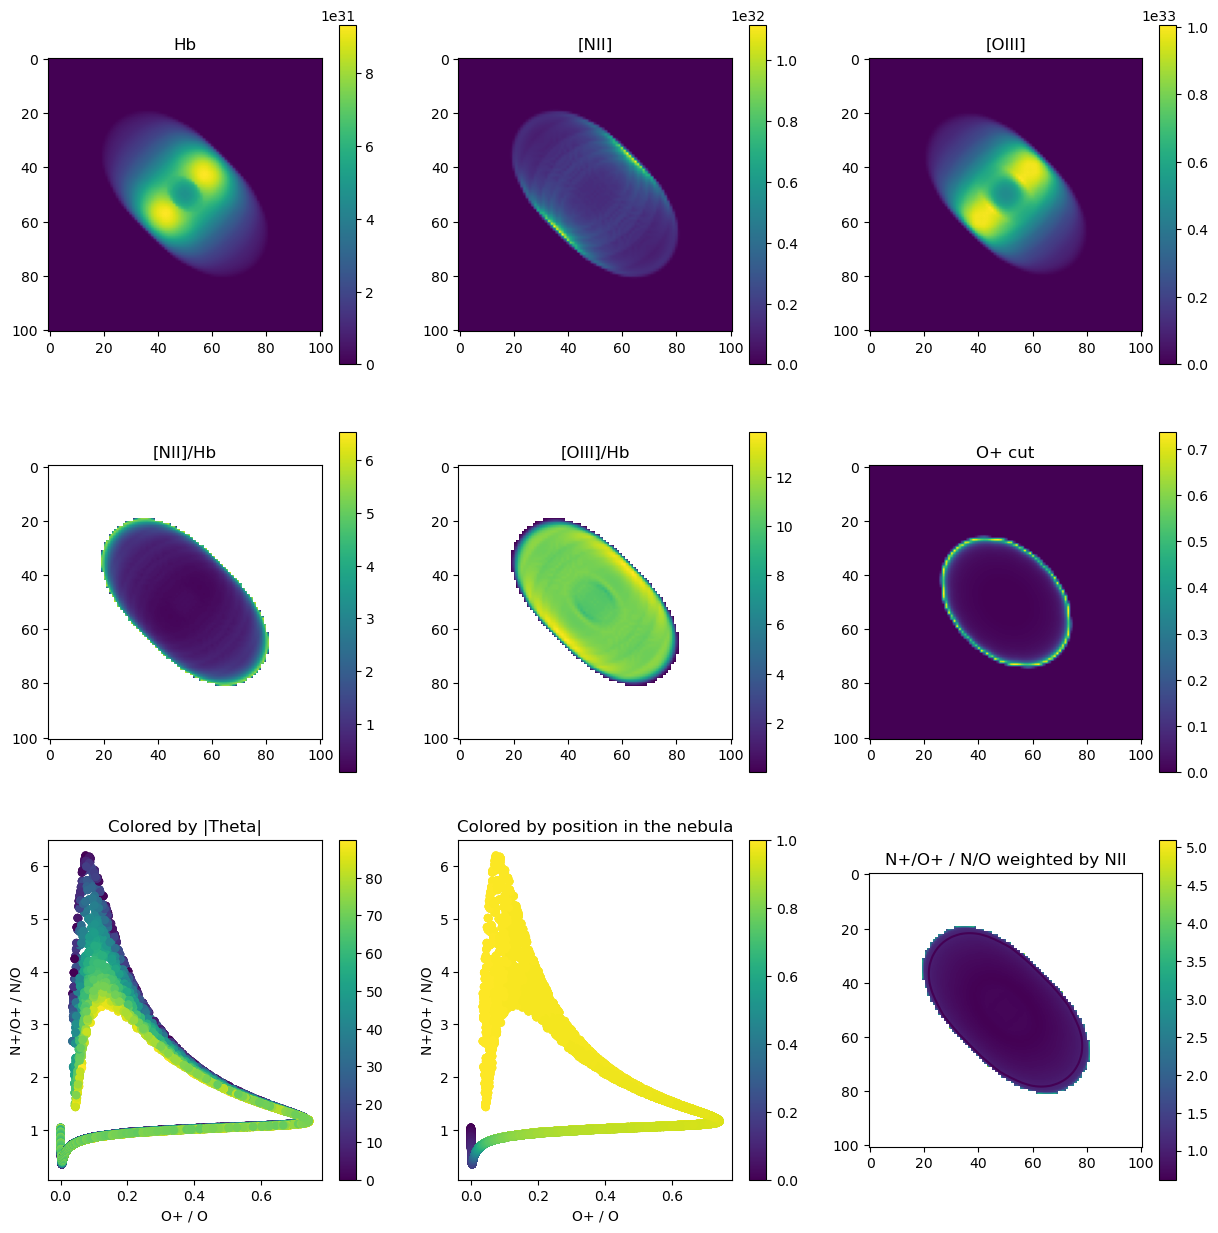

In [11]:
plt.figure(figsize=(15,15))
some_plots(m3d, proj_axis)

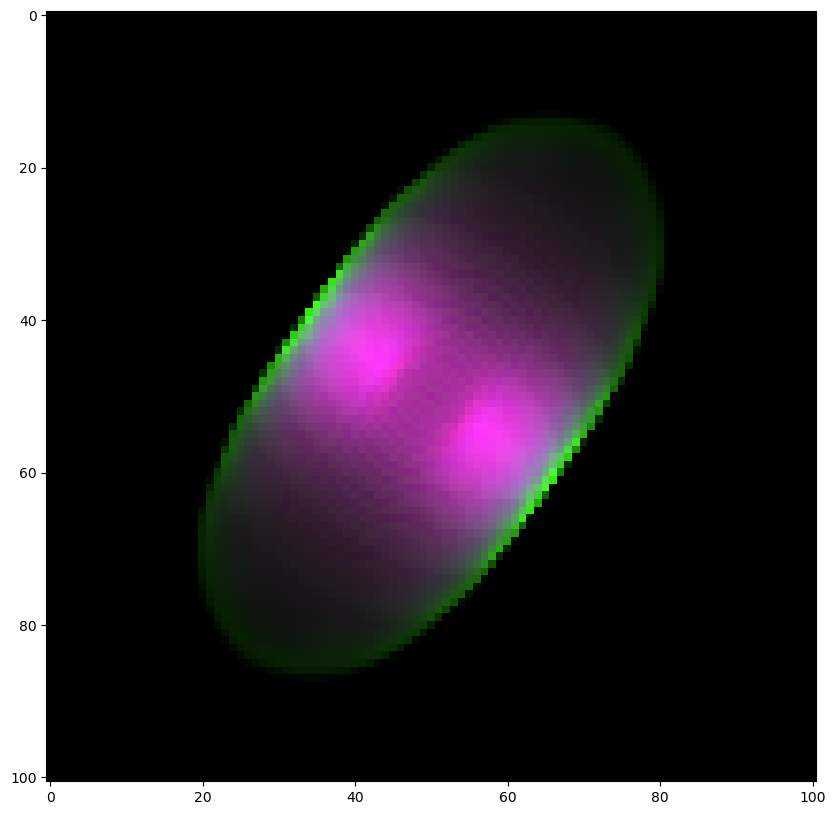

In [12]:
im = m3d.get_RGB(list_emis = [0, 3, 7])
plt.figure(1, figsize=(10,10))
plt.imshow(im)

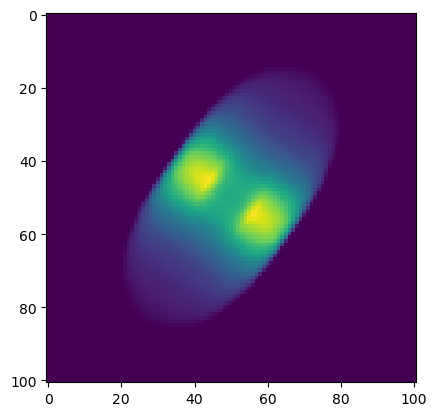

In [13]:
plt.imshow(m3d.get_emis('O__3_500684A').sum(axis=2))